In [1]:
from advertorch.utils import predict_from_logits
from advertorch_examples.utils import _imshow
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, precision_recall_fscore_support
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
import os
import matplotlib.pyplot as plt
import numpy as np
import pickle
import random
import torch
import tqdm.notebook as tqdm

In [2]:
device = "cuda:0"
model_dir_path = "./model"
experiment_dir_path = "./experiment"
best_model_file_name = "original_best_model.pt"
random_seed = 777

In [3]:
random.seed(random_seed)
np.random.seed(random_seed)
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [4]:
test_dataset = datasets.ImageFolder(
    root="./dataset/casting_data/data/test",
    transform=transforms.Compose([
        transforms.Grayscale(),
        transforms.ToTensor()
    ])
)

In [5]:
test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=32,
    shuffle=False
)

In [6]:
class InspectionModel(nn.Module):
    
    def __init__(self):
        super(InspectionModel, self).__init__()
        
        self.conv_1 = nn.Sequential(
            nn.Conv2d(1, 8, 3),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv_2 = nn.Sequential(
            nn.Conv2d(8, 16, 3),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv_3 = nn.Sequential(
            nn.Conv2d(16, 16, 3),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2)
        )
        
        self.fc = nn.Sequential(
            nn.Linear(19600, 224),
            nn.ReLU(inplace=True),
            nn.Linear(224, 1)
        )
        
        
    def forward(self, x):
        x = self.conv_1(x)
        x = self.conv_2(x)
        x = self.conv_3(x)
        x = x.view(x.size()[0], -1)
        
#         conv_output_size = x.size()[-1]
#         print(conv_output_size)
        
        x = self.fc(x)
        x = torch.sigmoid(x)
        
        return x

## Load

In [7]:
model = InspectionModel()
model.load_state_dict(torch.load(os.path.join(model_dir_path, best_model_file_name), map_location="cpu"))
model.to(device)
model.eval()

InspectionModel(
  (conv_1): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_3): Sequential(
    (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Sequential(
    (0): Linear(in_features=19600, out_features=224, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=224, out_features=1, bias=True)
  )
)

## Generate Adv Examples

In [8]:
from advertorch.attacks import LinfPGDAttack

In [9]:
def predict_from_hypothesis(hypothesis, threshold):
    return (hypothesis > threshold).float()

In [10]:
def get_metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true=y_true, y_pred=y_pred)
    precision = precision_score(y_true=y_true, y_pred=y_pred)
    recall = recall_score(y_true=y_true, y_pred=y_pred)
    f1 = f1_score(y_true=y_true, y_pred=y_pred)
    tn, fp, fn, tp = confusion_matrix(y_true=y_true, y_pred=y_pred).ravel()

    return dict(
        accuracy=accuracy,
        precision=precision,
        recall=recall,
        f1=f1,
        tn=tn,
        fp=fp,
        fn=fn,
        tp=tp
    )

In [14]:
def experiment(model, eps_list, device, is_saved, experiment_name):
    device = device
    record_dict_list = list()
    threshold = 0.5
    
    for eps in tqdm.tqdm(eps_list):
        adversary = LinfPGDAttack(
            model,
            loss_fn=nn.BCELoss(),
            eps=eps,
            targeted=False
        )

        img_list = list()
        targeted_def_adv_img_list = list()
        targeted_ok_adv_img_list = list()
        untargeted_adv_img_list = list()
        label_list = list()
        pred_list = list()
        targeted_def_pred_list = list()
        targeted_ok_pred_list = list()
        untargeted_pred_list = list()

        for img_batch, label_batch in test_loader:
            img_batch = img_batch.to(device)
            label_batch = label_batch.to(device).float().unsqueeze(dim=1)

            # Untargeted adv data
            adversary.targeted = False
            untargeted_adv_img_batch = adversary.perturb(img_batch, label_batch)

            # Targeted adv data
            adversary.targeted = True
            targeted_def_label_batch = torch.ones_like(label_batch) * 0
            targeted_def_adv_img_batch = adversary.perturb(img_batch, targeted_def_label_batch)

            targeted_ok_label_batch = torch.ones_like(label_batch) * 1
            targeted_ok_adv_img_batch = adversary.perturb(img_batch, targeted_ok_label_batch)

            pred_label_batch = predict_from_hypothesis(model(img_batch), threshold=threshold)
            pred_untargeted_label_batch = predict_from_hypothesis(model(untargeted_adv_img_batch), threshold=threshold)
            pred_targeted_def_label_batch = predict_from_hypothesis(model(targeted_def_adv_img_batch), threshold=threshold)
            pred_targeted_ok_label_batch = predict_from_hypothesis(model(targeted_ok_adv_img_batch), threshold=threshold)

            # Append
            img_list.append(img_batch.cpu().detach().numpy().squeeze())
            targeted_def_adv_img_list.append(targeted_def_adv_img_batch.cpu().detach().numpy().squeeze())
            targeted_ok_adv_img_list.append(targeted_ok_adv_img_batch.cpu().detach().numpy().squeeze())
            untargeted_adv_img_list.append(untargeted_adv_img_batch.cpu().detach().numpy().squeeze())
            label_list.append(label_batch.cpu().detach().numpy().squeeze())

            pred_list.append(pred_label_batch.cpu().detach().numpy().squeeze())
            targeted_def_pred_list.append(pred_targeted_def_label_batch.cpu().detach().numpy().squeeze())
            targeted_ok_pred_list.append(pred_targeted_ok_label_batch.cpu().detach().numpy().squeeze())
            untargeted_pred_list.append(pred_untargeted_label_batch.cpu().detach().numpy().squeeze())


        img_list = np.concatenate(img_list, axis=0)
        targeted_def_adv_img_list = np.concatenate(targeted_def_adv_img_list, axis=0)
        targeted_ok_adv_img_list = np.concatenate(targeted_ok_adv_img_list, axis=0)
        untargeted_adv_img_list = np.concatenate(untargeted_adv_img_list, axis=0)

        label_list = np.concatenate(label_list, axis=0)
        pred_list = np.concatenate(pred_list, axis=0)
        targeted_def_pred_list = np.concatenate(targeted_def_pred_list, axis=0)
        targeted_ok_pred_list = np.concatenate(targeted_ok_pred_list, axis=0)
        untargeted_pred_list = np.concatenate(untargeted_pred_list, axis=0)

        clean_pred_metrics = get_metrics(y_true=label_list, y_pred=pred_list)
        targeted_def_pred_metrics = get_metrics(y_true=pred_list, y_pred=targeted_def_pred_list)
        targeted_ok_pred_metrics = get_metrics(y_true=pred_list, y_pred=targeted_ok_pred_list)
        untargeted_pred_metrics = get_metrics(y_true=pred_list, y_pred=untargeted_pred_list)

        record_dict=dict(
            eps=eps,
            
            img_list=img_list,
            targeted_def_adv_img_list=targeted_def_adv_img_list,
            targeted_ok_adv_img_list=targeted_ok_adv_img_list,
            untargeted_adv_img_list=untargeted_adv_img_list,

            label_list = label_list,
            pred_list = pred_list,
            targeted_def_pred_list=targeted_def_pred_list,
            targeted_ok_pred_list=targeted_ok_pred_list,
            untargeted_pred_list=untargeted_pred_list,

            clean_pred_metrics=clean_pred_metrics,
            targeted_def_pred_metrics=targeted_def_pred_metrics,
            targeted_ok_pred_metrics=targeted_ok_pred_metrics,
            untargeted_pred_metrics=untargeted_pred_metrics
        )
        
        record_dict_list.append(record_dict)
    
    if is_saved:
        with open(os.path.join(experiment_dir_path, f"{experiment_name}.pkl"), "wb") as f:
            pickle.dump(record_dict_list, f, protocol=pickle.HIGHEST_PROTOCOL)
    
    return record_dict_list

In [15]:
record_dict_list = experiment(
    model=model,
    eps_list=np.arange(0.0, 0.100, 0.01),
    device=device,
    is_saved=True,
    experiment_name="infpgd_000_to_0100"
)

  0%|          | 0/10 [00:00<?, ?it/s]

## Analysis

In [16]:
def get_new_score_dict(record_dict_list, category):
    return dict(
        fpr_list=list(map(lambda record_dict: record_dict[category]["fp"] / (record_dict[category]["tn"] + record_dict[category]["fp"]), record_dict_list)),
        fnr_list=list(map(lambda record_dict: record_dict[category]["fn"] / (record_dict[category]["fn"] + record_dict[category]["tp"]), record_dict_list)),
        mr_list=list(map(lambda record_dict: (record_dict[category]["fp"] + record_dict[category]["fn"]) / len(record_dict["targeted_def_pred_list"]), record_dict_list))
    )

In [17]:
def get_best_new_score_dict(new_score_dict):
    best_fpr = [0, 0]
    best_fnr = [0, 0]
    best_mr = [0, 0]
    
    for i, fpr in enumerate(new_score_dict['fpr_list']):
        if fpr > best_fpr[1]:
            best_fpr[1] = fpr
            best_fpr[0] = i
    
    for i, fnr in enumerate(new_score_dict['fnr_list']):
        if fnr > best_fnr[1]:
            best_fnr[1] = fnr
            best_fnr[0] = i
    
    for i, mr in enumerate(new_score_dict['mr_list']):
        if mr > best_mr[1]:
            best_mr[1] = mr
            best_mr[0] = i
    
    return dict(
        best_fpr=best_fpr,
        best_fnr=best_fnr,
        best_mr=best_mr
    )

In [20]:
with open(os.path.join(experiment_dir_path, f"infpgd_000_to_0100.pkl"), "rb") as f:
    test_record_dict_list = pickle.load(f)

In [24]:
for i, record_dict in enumerate(test_record_dict_list):
#     print(record_dict["clean_pred_metrics"])
#     print(i, record_dict["targeted_def_pred_metrics"])
    print(i, record_dict["targeted_ok_pred_metrics"])
#     print(record_dict["untargeted_pred_metrics"])

0 {'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0, 'f1': 1.0, 'tn': 43, 'fp': 0, 'fn': 0, 'tp': 28}
1 {'accuracy': 0.8309859154929577, 'precision': 0.7, 'recall': 1.0, 'f1': 0.8235294117647058, 'tn': 31, 'fp': 12, 'fn': 0, 'tp': 28}
2 {'accuracy': 0.5492957746478874, 'precision': 0.4666666666666667, 'recall': 1.0, 'f1': 0.6363636363636364, 'tn': 11, 'fp': 32, 'fn': 0, 'tp': 28}
3 {'accuracy': 0.43661971830985913, 'precision': 0.4117647058823529, 'recall': 1.0, 'f1': 0.5833333333333334, 'tn': 3, 'fp': 40, 'fn': 0, 'tp': 28}
4 {'accuracy': 0.4084507042253521, 'precision': 0.4, 'recall': 1.0, 'f1': 0.5714285714285715, 'tn': 1, 'fp': 42, 'fn': 0, 'tp': 28}
5 {'accuracy': 0.39436619718309857, 'precision': 0.39436619718309857, 'recall': 1.0, 'f1': 0.5656565656565656, 'tn': 0, 'fp': 43, 'fn': 0, 'tp': 28}
6 {'accuracy': 0.39436619718309857, 'precision': 0.39436619718309857, 'recall': 1.0, 'f1': 0.5656565656565656, 'tn': 0, 'fp': 43, 'fn': 0, 'tp': 28}
7 {'accuracy': 0.39436619718309857, 'pr

In [27]:
ok_targeted_new_score_dict = get_new_score_dict(
    record_dict_list=test_record_dict_list[1:],
    category="targeted_ok_pred_metrics"
)

def_targeted_new_score_dict = get_new_score_dict(
    record_dict_list=test_record_dict_list[1:],
    category="targeted_def_pred_metrics"
)

untargeted_targeted_new_score_dict = get_new_score_dict(
    record_dict_list=test_record_dict_list[1:],
    category="untargeted_pred_metrics"
)

In [28]:
ok_targeted_best_score_dict = get_best_new_score_dict(ok_targeted_new_score_dict)
def_targeted_best_score_dict = get_best_new_score_dict(def_targeted_new_score_dict)
untargeted_best_score_dict = get_best_new_score_dict(untargeted_targeted_new_score_dict)

In [29]:
ok_targeted_best_score_idx = ok_targeted_best_score_dict["best_mr"][0]
ok_targeted_best_score_dict["best_mr"]

[4, 0.6056338028169014]

In [30]:
def_targeted_best_score_idx = def_targeted_best_score_dict["best_mr"][0]
def_targeted_best_score_dict["best_mr"]

[1, 0.36619718309859156]

In [31]:
untargeted_best_score_idx = untargeted_best_score_dict["best_mr"][0]
untargeted_best_score_dict["best_mr"]

[3, 0.8591549295774648]

In [32]:
ok_targeted_best_record_dict = test_record_dict_list[1:][ok_targeted_best_score_idx]  # targeted_ok_adv_img_list
def_targeted_best_record_dict = test_record_dict_list[1:][def_targeted_best_score_idx]  # targeted_def_adv_img_list
untargeted_best_record_dict = test_record_dict_list[1:][untargeted_best_score_idx]  # untargeted_adv_img_list

In [33]:
ok_targeted_best_record_dict["clean_pred_metrics"]

{'accuracy': 0.9154929577464789,
 'precision': 0.8571428571428571,
 'recall': 0.9230769230769231,
 'f1': 0.888888888888889,
 'tn': 41,
 'fp': 4,
 'fn': 2,
 'tp': 24}

In [34]:
ok_targeted_best_record_dict["targeted_ok_pred_metrics"]

{'accuracy': 0.39436619718309857,
 'precision': 0.39436619718309857,
 'recall': 1.0,
 'f1': 0.5656565656565656,
 'tn': 0,
 'fp': 43,
 'fn': 0,
 'tp': 28}

In [35]:
def_targeted_best_record_dict["targeted_def_pred_metrics"]

{'accuracy': 0.6338028169014085,
 'precision': 1.0,
 'recall': 0.07142857142857142,
 'f1': 0.13333333333333333,
 'tn': 43,
 'fp': 0,
 'fn': 26,
 'tp': 2}

In [36]:
untargeted_best_record_dict["untargeted_pred_metrics"]

{'accuracy': 0.14084507042253522,
 'precision': 0.14893617021276595,
 'recall': 0.25,
 'f1': 0.18666666666666665,
 'tn': 3,
 'fp': 40,
 'fn': 21,
 'tp': 7}

## Visualization

In [38]:
def show_img_from_record_dict(record_dict, category, idx, figsize=(4, 10)):
    adversarial_img_category = ""
    adversarial_pred_categoty = ""
        
    if category == "ok_targeted":
        adversarial_img_category = "targeted_ok_adv_img_list"
        adversarial_pred_categoty = "targeted_ok_pred_list"
    elif category == "def_targeted":
        adversarial_img_category = "targeted_def_adv_img_list"
        adversarial_pred_categoty = "targeted_def_pred_list"
    elif category == "untargeted":
        adversarial_img_category = "untargeted_adv_img_list"
        adversarial_pred_categoty = "untargeted_pred_list"
        
    
    original_img = record_dict["img_list"][idx]
    adversarial_img = record_dict[adversarial_img_category][idx]
    
    pred = "OK" if record_dict["pred_list"][idx] else "Defect"
    adv_pred = "OK" if record_dict[adversarial_pred_categoty][idx] else "Defect"
    
    fig, ax = plt.subplots(nrows=2, ncols=1, figsize=figsize)
    ax[0].imshow(original_img, cmap='gray')
    ax[0].set_title(f"Original Image\nPredict : {pred}")
    
    ax[1].imshow(adversarial_img, cmap='gray')
    if category == "ok_targeted":
        ax[1].set_title(f"OK Targeted Adversarial Example\nPredict : {adv_pred}")
    elif category == "def_targeted":
        ax[1].set_title(f"Defect Targeted Adversarial Example\nPredict : {adv_pred}")
    elif category == "untargeted":
        ax[1].set_title(f"Untargeted Adversarial Example\nPredict : {adv_pred}")
        
    plt.show()

In [59]:
from PIL import Image

def save_img_from_record_dict(record_dict, category, save_dir_path, sample_size=10, figsize=(4, 10), is_saved=False):
    adversarial_img_category = ""
    adversarial_pred_categoty = ""
        
    if category == "ok_targeted":
        adversarial_img_category = "targeted_ok_adv_img_list"
        adversarial_pred_categoty = "targeted_ok_pred_list"
    elif category == "def_targeted":
        adversarial_img_category = "targeted_def_adv_img_list"
        adversarial_pred_categoty = "targeted_def_pred_list"
    elif category == "untargeted":
        adversarial_img_category = "untargeted_adv_img_list"
        adversarial_pred_categoty = "untargeted_pred_list"
        
    
    for idx in tqdm.tqdm(range(sample_size)):
        original_img = record_dict["img_list"][idx]
        adversarial_img = record_dict[adversarial_img_category][idx]

        pred = "OK" if record_dict["pred_list"][idx] else "Defect"
        adv_pred = "OK" if record_dict[adversarial_pred_categoty][idx] else "Defect"

        fig, ax = plt.subplots(nrows=2, ncols=1, figsize=figsize)
        ax[0].imshow(original_img, cmap='gray')
        ax[0].set_title(f"Original Image\nPredict : {pred}")

        ax[1].imshow(adversarial_img, cmap='gray')
        if category == "ok_targeted":
            ax[1].set_title(f"OK Targeted Adversarial Example\nPredict : {adv_pred}")
        elif category == "def_targeted":
            ax[1].set_title(f"Defect Targeted Adversarial Example\nPredict : {adv_pred}")
        elif category == "untargeted":
            ax[1].set_title(f"Untargeted Adversarial Example\nPredict : {adv_pred}")
        
        if is_saved:
            plt.savefig(os.path.join(save_dir_path, category, f"{idx}.png"), dpi=300)

  0%|          | 0/10 [00:00<?, ?it/s]

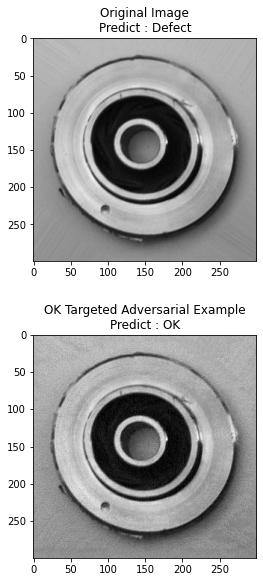

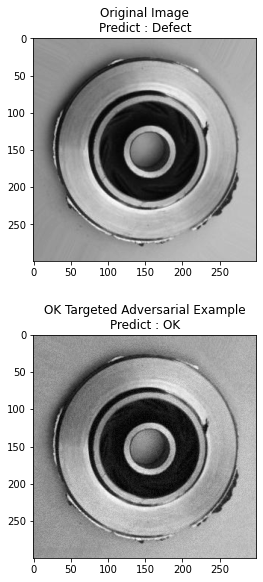

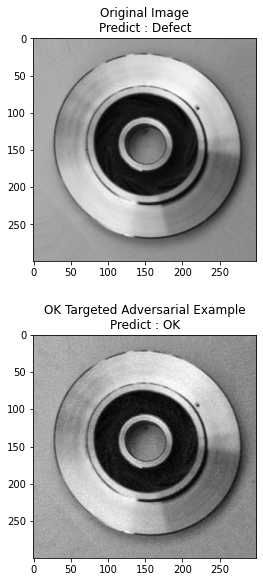

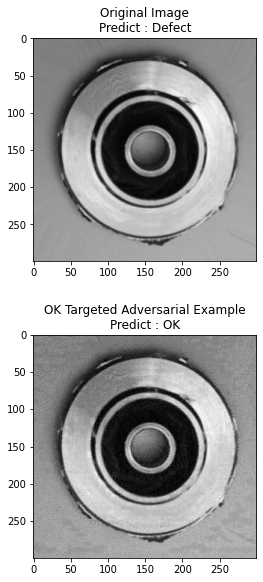

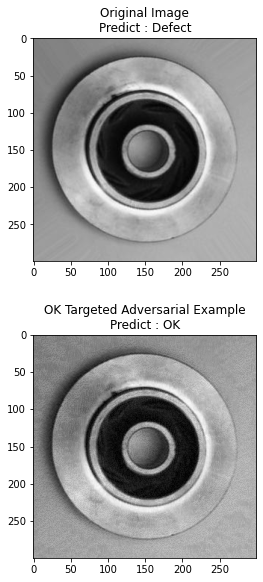

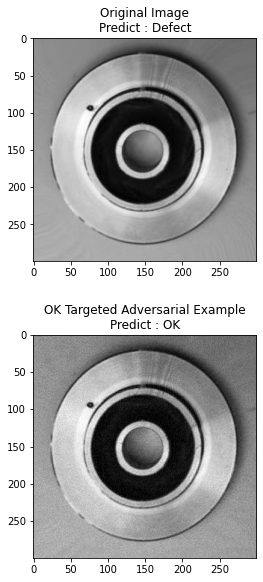

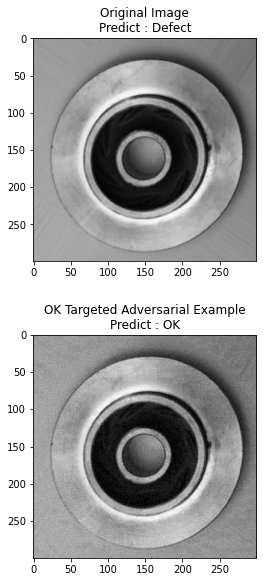

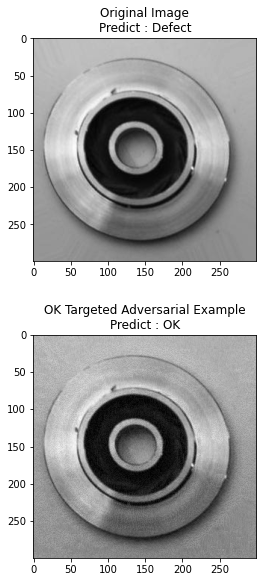

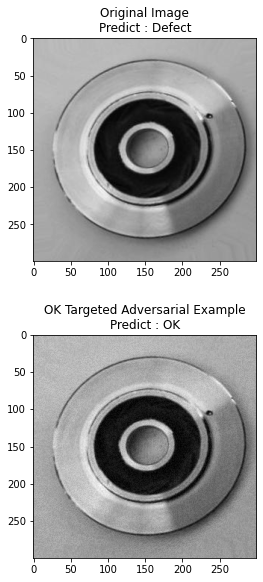

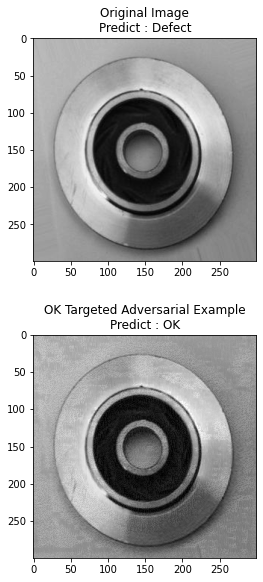

In [63]:
save_img_from_record_dict(
    record_dict=ok_targeted_best_record_dict,
    category="ok_targeted",
    save_dir_path="./experiment/result_img/infpgd",
    sample_size=10,
    is_saved=False
)

  0%|          | 0/10 [00:00<?, ?it/s]

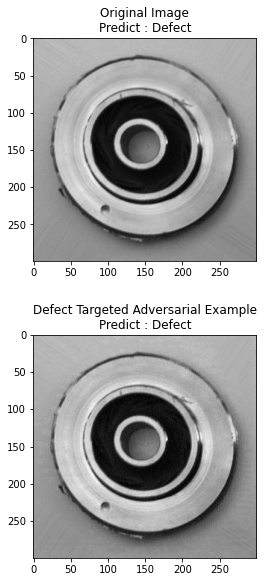

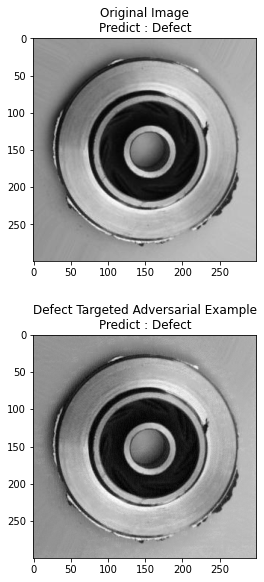

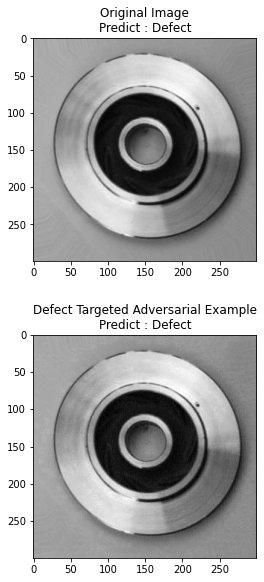

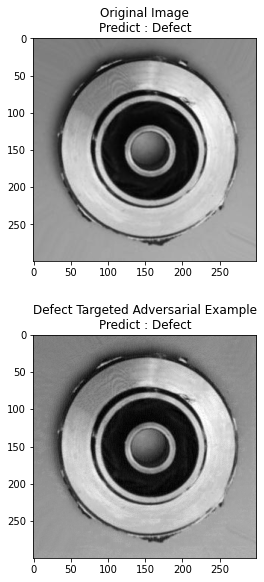

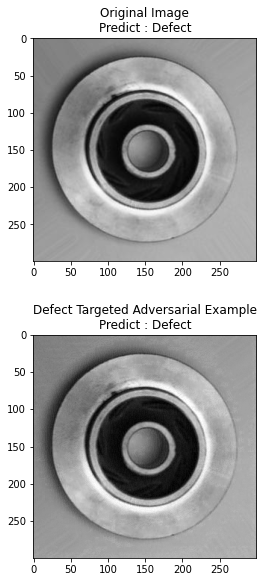

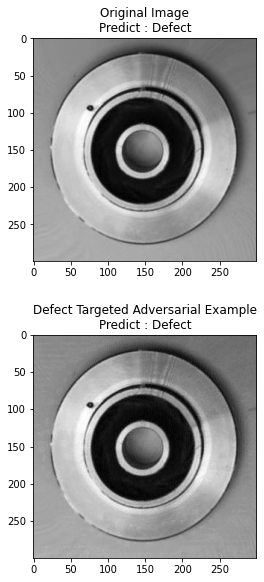

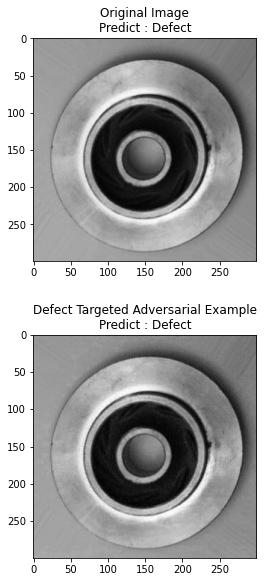

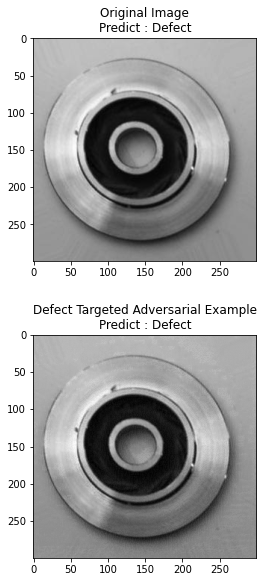

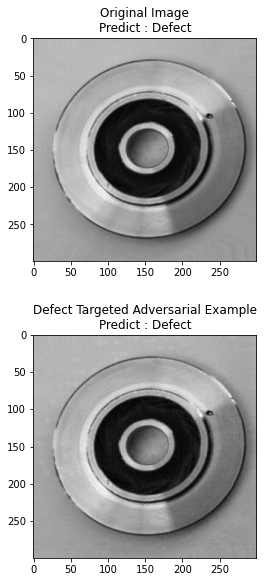

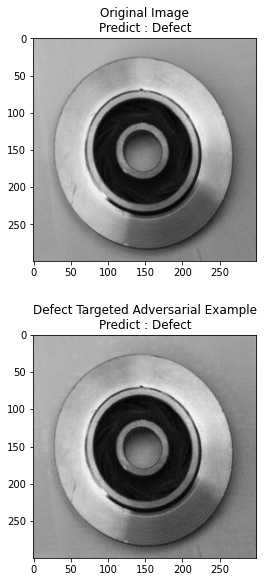

In [64]:
save_img_from_record_dict(
    record_dict=def_targeted_best_record_dict,
    category="def_targeted",
    save_dir_path="./experiment/result_img/infpgd",
    sample_size=10,
    is_saved=False
)

  0%|          | 0/10 [00:00<?, ?it/s]

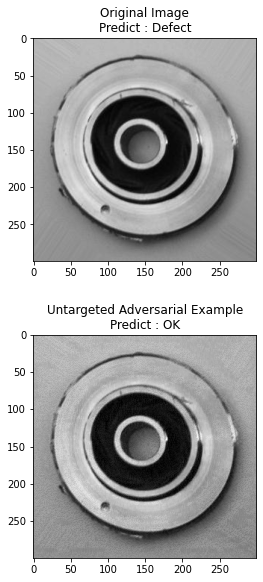

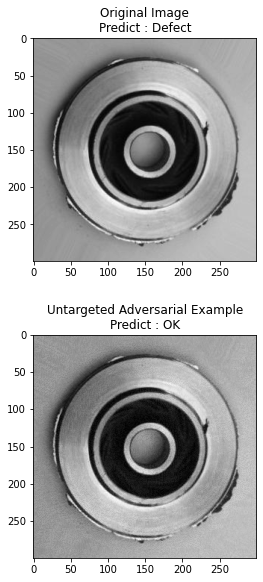

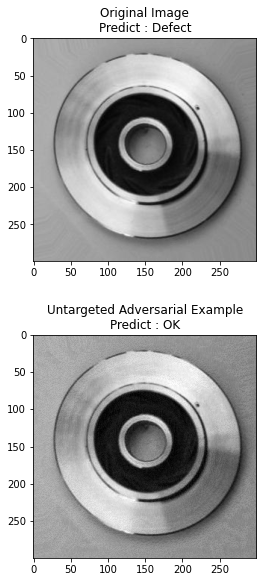

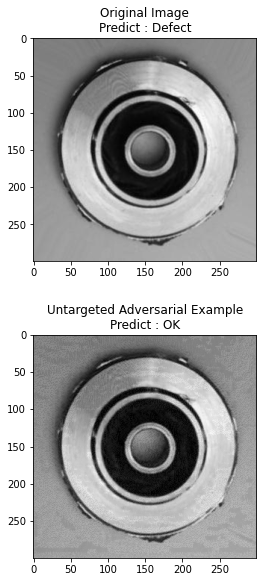

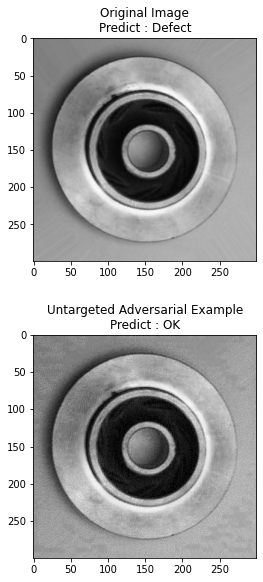

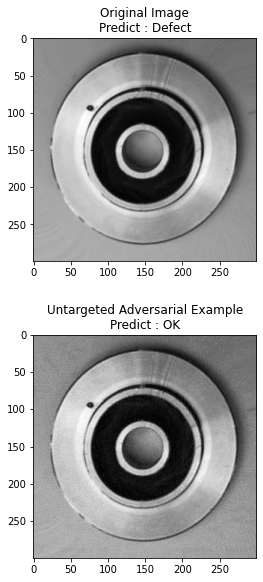

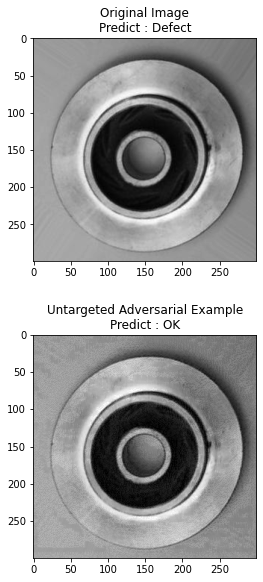

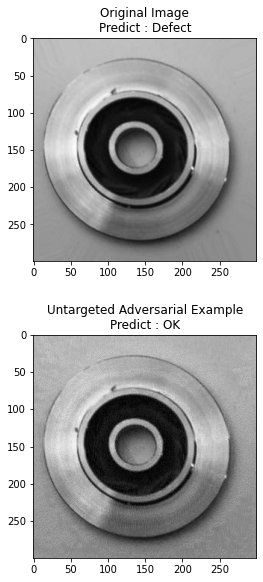

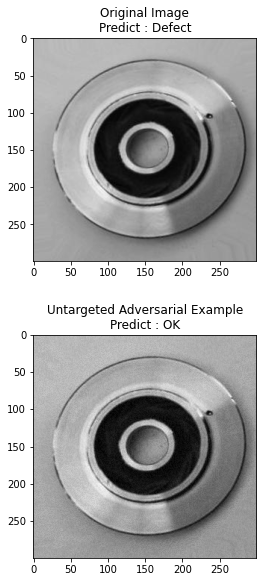

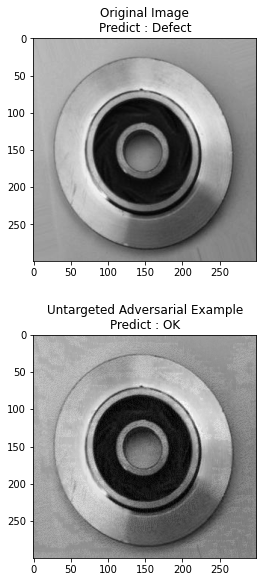

In [65]:
save_img_from_record_dict(
    record_dict=untargeted_best_record_dict,
    category="untargeted",
    save_dir_path="./experiment/result_img/infpgd",
    sample_size=10,
    is_saved=False
)

## Visualization

In [45]:
def plot_result(record_dict_list, category, best_idx, title, ax=None, y_lim=(-0.02, 1.02), figsize=(15, 7)):
    if ax is None:
        plt.figure(figsize=figsize)
        ax = plt.gca()
        
    best_eps = record_dict_list[best_idx]["eps"]
    
    ax.plot(list(map(lambda record_dict: record_dict["eps"], record_dict_list)), list(map(lambda record_dict: record_dict[category]["fp"] / (record_dict[category]["tn"] + record_dict[category]["fp"]), record_dict_list)), label="FPR", linestyle="dashdot", color="blue")
    ax.plot(list(map(lambda record_dict: record_dict["eps"], record_dict_list)), list(map(lambda record_dict: record_dict[category]["fn"] / (record_dict[category]["fn"] + record_dict[category]["tp"]), record_dict_list)), label="FNR", linestyle="dotted", color="green")
    ax.plot(list(map(lambda record_dict: record_dict["eps"], record_dict_list)), list(map(lambda record_dict: (record_dict[category]["fp"] + record_dict[category]["fn"]) / len(record_dict["targeted_def_pred_list"]), record_dict_list)), label="MR", color="red")
    ax.axvline(x=best_eps, linestyle="--", label=f"Best value : {round(best_eps, 3)}", color="black")
    
    ax.set_ylim(y_lim)
    ax.set_xlabel("eps", fontsize=17)
    ax.set_ylabel("Score", fontsize=17)
    ax.set_title(title, fontsize=15)
    ax.tick_params(axis='x', labelsize=15)
    ax.tick_params(axis='y', labelsize=15)
    ax.legend(fontsize=15)
    
    ax.xaxis.grid(True)
    ax.yaxis.grid(True)
    
    plt.tight_layout()
#     plt.savefig(f"./{save_file_name}.png", dpi=300)

    return ax

<AxesSubplot:title={'center':'PGD - Metrics Graph of OK Targeted Adversarial Attack'}, xlabel='eps', ylabel='Score'>

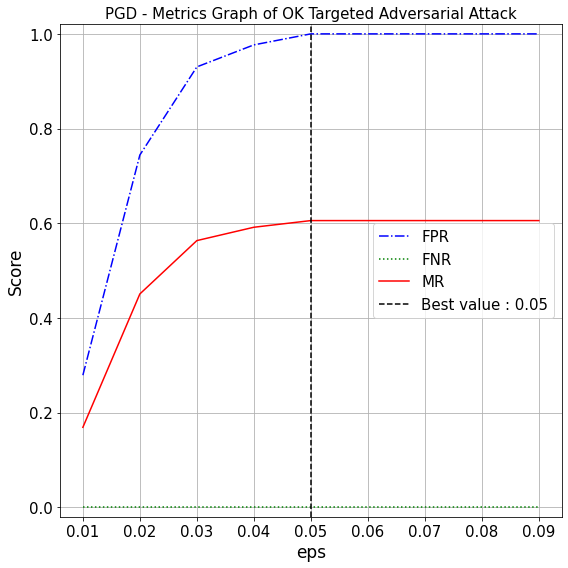

In [51]:
plot_result(
    record_dict_list=test_record_dict_list[1:],
    category="targeted_ok_pred_metrics",
    best_idx=ok_targeted_best_score_idx,
    title="PGD - Metrics Graph of OK Targeted Adversarial Attack",
    figsize=(8, 8)
)

<AxesSubplot:title={'center':'PGD - Metrics Graph of Defect Targeted Adversarial Attack'}, xlabel='eps', ylabel='Score'>

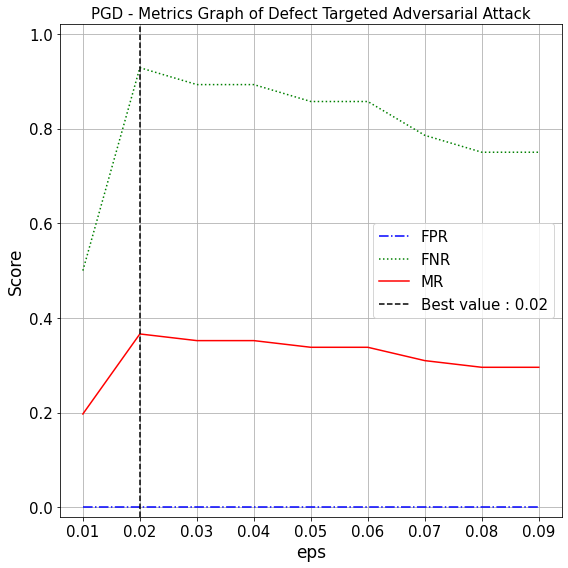

In [52]:
plot_result(
    record_dict_list=test_record_dict_list[1:],
    category="targeted_def_pred_metrics",
    best_idx=def_targeted_best_score_idx,
    title="PGD - Metrics Graph of Defect Targeted Adversarial Attack",
    figsize=(8, 8)
)

<AxesSubplot:title={'center':'PGD - Metrics Graph of Untargeted Adversarial Attack'}, xlabel='eps', ylabel='Score'>

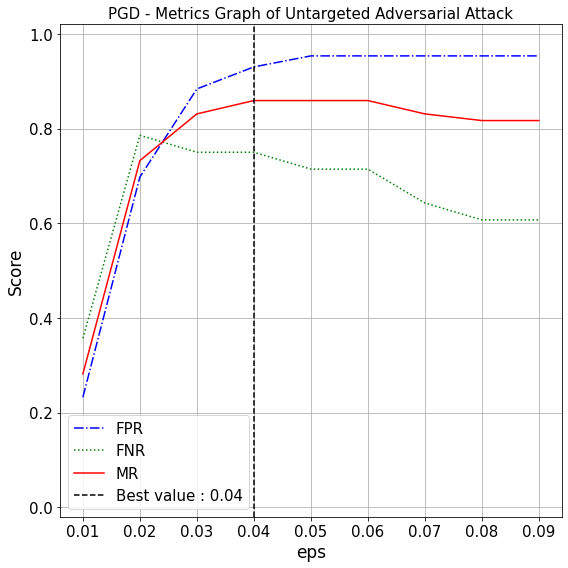

In [53]:
plot_result(
    record_dict_list=test_record_dict_list[1:],
    category="untargeted_pred_metrics",
    best_idx=untargeted_best_score_idx,
    title="PGD - Metrics Graph of Untargeted Adversarial Attack",
    figsize=(8, 8)
)